<H1>Load Datasets<H1>

In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

path = os.getcwd()

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

bracket_training = pd.read_csv(f"{path}/bracket_training.csv", sep= ",")
# bracket_training

bracket_test = pd.read_csv(f'{path}/bracket_test.csv')

college_info = pd.read_csv(f'{path}/institutions.csv', sep = ',', encoding= 'utf-8')

df_kenpom = pd.read_csv('Kenpom Data.csv')

distances_ew_df = pd.read_csv(f'{path}/SemifinalWinner_East_West.csv', sep = '|')


# --- Step 1: Extract the full team name (excluding the trailing seed rank)
# Instead of taking only the first token, we remove the last token (which is the seed rank)
df_kenpom['Team_Name'] = df_kenpom['Team'].apply(lambda x: ' '.join(x.split()[:-1]))

# --- Step 2: Apply manual corrections to match college_info['Institution_Name']
# Mapping dictionary: keys are the names extracted from KenPom and values are the correct names from college_info.
mapping = {
    # Changes applied:
    "Connecticut": "UConn",            # "Connecticut" → "UConn"
    "Houston": "Houston",              # No change needed
    "Purdue": "Purdue",                # No change needed
    "Auburn": "Auburn",                # No change needed
    "Tennessee": "Tennessee",          # No change needed
    "Arizona": "Arizona",              # No change needed
    "Duke": "Duke",                    # No change needed
    "Iowa St.": "Iowa St.",             # No change needed
    "North Carolina": "North Carolina",# No change needed
    "Illinois": "Illinois",            # No change needed
    "Creighton": "Creighton",          # No change needed
    "Gonzaga": "Gonzaga",              # No change needed
    "Marquette": "Marquette",          # No change needed
    "Alabama": "Alabama",              # No change needed
    "Baylor": "Baylor",                # No change needed
    "Michigan St.": "Michigan St.",     # No change needed
    "Wisconsin": "Wisconsin",          # No change needed
    "BYU": "BYU",                      # No change needed
    "Clemson": "Clemson",              # No change needed
    "Saint Mary's": "Saint Mary's",    # No change needed
    "San Diego St.": "San Diego St.",   # No change needed
    "Kentucky": "Kentucky",            # No change needed
    "Colorado": "Colorado",            # No change needed
    "Texas": "Texas",                  # No change needed
    "Florida": "Florida",              # No change needed
    "Kansas": "Kansas",                # No change needed
    "New Mexico": "New Mexico",        # No change needed
    "Nebraska": "Nebraska",            # No change needed
    "Texas Tech": "Texas Tech",        # No change needed
    "Dayton": "Dayton",                # No change needed
    "Mississippi St.": "Mississippi St.",# No change needed
    "Texas A&M": "Texas A&M",          # No change needed
    "Colorado St.": "Colorado St.",    # No change needed
    "Nevada": "Nevada",                # No change needed
    "Northwestern": "Northwestern",    # No change needed
    "Washington St.": "Washington St.",# No change needed
    "TCU": "TCU",                    # No change needed
    "Boise St.": "Boise St.",          # No change needed
    "N.C. State": "NC State",          # "N.C. State" → "NC State" (remove periods)
    "Florida Atlantic": "FAU",         # "Florida Atlantic" → "FAU"
    "Utah St.": "Utah St.",            # No change needed
    "Grand Canyon": "Grand Canyon",    # No change needed
    "Drake": "Drake",                  # No change needed
    "South Carolina": "South Carolina",# No change needed
    "Oregon": "Oregon",                # No change needed
    "James Madison": "James Madison",  # No change needed
    "McNeese St.": "McNeese",           # "McNeese St." → "McNeese"
    "Virginia": "Virginia",            # No change needed
    "Samford": "Samford",              # No change needed
    "Duquesne": "Duquesne",            # No change needed
    "Yale": "Yale",                    # No change needed
    "Charleston": "Charleston",        # No change needed
    "Vermont": "Vermont",              # No change needed
    "UAB": "UAB",                      # No change needed
    "Morehead St.": "Morehead St.",     # No change needed
    "Akron": "Akron",                  # No change needed
    "Oakland": "Oakland",              # No change needed
    "Western Kentucky": "Western Ky.", # "Western Kentucky" → "Western Ky."
    "South Dakota St.": "South Dakota St.",# No change needed
    "Colgate": "Colgate",              # No change needed
    "Longwood": "Longwood",            # No change needed
    "Long Beach St.": "Long Beach St.",# No change needed
    "Saint Peter's": "Saint Peter's",  # No change needed
    "Stetson": "Stetson",              # No change needed
    "Montana St.": "Montana St.",      # No change needed
    "Grambling St.": "Grambling St.",    # No change needed
    "Howard": "Howard",                # No change needed
    "Wagner": "Wagner"                 # No change needed
}

# Apply the mapping so that each Team_Name matches college_info['Institution_Name']
df_kenpom['Team_Name'] = df_kenpom['Team_Name'].map(mapping)

# --- Step 3: Process the Seed_Rank column
df_kenpom['Seed_Rank'] = df_kenpom['Team'].str.extract(r'(\d+)$')
df_kenpom = df_kenpom.dropna(subset=['Seed_Rank'])
df_kenpom['Seed_Rank'] = df_kenpom['Seed_Rank'].astype(int)

# Create a cleaned DataFrame with selected columns and set index as Team_Name
df_ken_clean = df_kenpom.loc[:, ['Rk', 'Team_Name', 'Seed_Rank', 'NetRtg', 'Luck']]
df_ken_clean = df_ken_clean.set_index('Team_Name')

# --- Step 4: Merge with the college_info dataset
# Now, set the index of college_info to 'Institution_Name' to match
college_info_ken_df = college_info.join(df_ken_clean, how='left', on='InstitutionName')

#Fast way to create new columns
college_info_ken_df['win_%'] = college_info_ken_df['RegularSeasonWins']/ (college_info_ken_df['RegularSeasonWins'] + college_info_ken_df['RegularSeasonLosses'])

#Join Ken info to bracket training and bracket test
college_info_ken_df = college_info_ken_df.set_index('InstitutionID')
train_df = bracket_training.join(
    college_info_ken_df.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_ken_df.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_ken_df.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_ken_df.add_prefix('S_'), on='RegionWinner_South'
)

test_df = bracket_test.join(
    college_info_ken_df.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_ken_df.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_ken_df.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_ken_df.add_prefix('S_'), on='RegionWinner_South'
)

classic1_df_train = train_df[
    [
        'CustomerID',
        #'CustomerAreaCode', 'CustomerPostalCode',
       'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
       'CustomerDMACode',
        'CustomerDMADescription',
       'NCAACustomerRecordCreated', 'BracketEntryId',
       'BracketEntryCreatedDate', 'RegionWinner_East', 'RegionWinner_West',
       'RegionWinner_South', 'RegionWinner_Midwest',
       'SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest',
       'NationalChampion',
       'E_InstitutionName',
        # 'E_InstitutionNickname',
        #'E_InstitutionAbbreviation', 'E_InstitutionCity',
        #'E_InstitutionState', 'E_InstitutionPostalCode',
       'E_InstitutionDMACode',
        # 'E_InstitutionDMADescription',
       'E_InstitutionLatitude', 'E_InstitutionLongitude',
       'E_InstitutionConference', 'E_InstitutionEnrollment_Male',
       'E_InstitutionEnrollment_Female', 'E_InstitutionEnrollment_Total',
       'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
       'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance',
       'E_RegularSeasonAverageScore',
       'E_Rk',
       'E_Seed_Rank', 'E_NetRtg', 'E_Luck',
       'M_InstitutionName',
        # 'M_InstitutionNickname',
        #'M_InstitutionAbbreviation', 'M_InstitutionCity',
        #'M_InstitutionState', 'M_InstitutionPostalCode',
       'M_InstitutionDMACode',
        # 'M_InstitutionDMADescription',
       'M_InstitutionLatitude', 'M_InstitutionLongitude',
       'M_InstitutionConference', 'M_InstitutionEnrollment_Male',
       'M_InstitutionEnrollment_Female', 'M_InstitutionEnrollment_Total',
       'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
       'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance',
       'M_RegularSeasonAverageScore',
       'M_Rk',
       'M_Seed_Rank', 'M_NetRtg', 'M_Luck',
       'S_InstitutionName',
        # 'S_InstitutionNickname',
        #'S_InstitutionAbbreviation', 'S_InstitutionCity',
        #'S_InstitutionState', 'S_InstitutionPostalCode',
       'S_InstitutionDMACode',
        # 'S_InstitutionDMADescription',
       'S_InstitutionLatitude', 'S_InstitutionLongitude',
       'S_InstitutionConference', 'S_InstitutionEnrollment_Male',
       'S_InstitutionEnrollment_Female', 'S_InstitutionEnrollment_Total',
       'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
       'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance',
       'S_RegularSeasonAverageScore',
       'S_Rk',
       'S_Seed_Rank', 'S_NetRtg', 'S_Luck',
       'W_InstitutionName',
        #'W_InstitutionNickname', 'W_InstitutionAbbreviation',
        #'W_InstitutionCity', 'W_InstitutionState', 'W_InstitutionPostalCode',
       'W_InstitutionDMACode',
        #'W_InstitutionDMADescription',
       'W_InstitutionLatitude', 'W_InstitutionLongitude',
       'W_InstitutionConference',
       'W_InstitutionEnrollment_Male',
       'W_InstitutionEnrollment_Female', 'W_InstitutionEnrollment_Total',
       'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
       'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance',
       'W_RegularSeasonAverageScore',
       'W_Rk',
       'W_Seed_Rank', 'W_NetRtg', 'W_Luck',
    ]
]

classic1_df_test = test_df[
    [
        'CustomerID',
        #'CustomerAreaCode', 'CustomerPostalCode',
       'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
       'CustomerDMACode',
        'CustomerDMADescription',
       'NCAACustomerRecordCreated', 'BracketEntryId',
       'BracketEntryCreatedDate', 'RegionWinner_East', 'RegionWinner_West',
       'RegionWinner_South', 'RegionWinner_Midwest',
       'E_InstitutionName',
        # 'E_InstitutionNickname',
        #'E_InstitutionAbbreviation', 'E_InstitutionCity',
        #'E_InstitutionState', 'E_InstitutionPostalCode',
       'E_InstitutionDMACode',
        # 'E_InstitutionDMADescription',
       'E_InstitutionLatitude', 'E_InstitutionLongitude',
       'E_InstitutionConference', 'E_InstitutionEnrollment_Male',
       'E_InstitutionEnrollment_Female', 'E_InstitutionEnrollment_Total',
       'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
       'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance',
       'E_RegularSeasonAverageScore',
       'E_Rk',
       'E_Seed_Rank', 'E_NetRtg', 'E_Luck',
       'M_InstitutionName',
        # 'M_InstitutionNickname',
        #'M_InstitutionAbbreviation', 'M_InstitutionCity',
        #'M_InstitutionState', 'M_InstitutionPostalCode',
       'M_InstitutionDMACode',
        # 'M_InstitutionDMADescription',
       'M_InstitutionLatitude', 'M_InstitutionLongitude',
       'M_InstitutionConference', 'M_InstitutionEnrollment_Male',
       'M_InstitutionEnrollment_Female', 'M_InstitutionEnrollment_Total',
       'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
       'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance',
       'M_RegularSeasonAverageScore',
       'M_Rk',
       'M_Seed_Rank', 'M_NetRtg', 'M_Luck',
       'S_InstitutionName',
        # 'S_InstitutionNickname',
        #'S_InstitutionAbbreviation', 'S_InstitutionCity',
        #'S_InstitutionState', 'S_InstitutionPostalCode',
       'S_InstitutionDMACode',
        # 'S_InstitutionDMADescription',
       'S_InstitutionLatitude', 'S_InstitutionLongitude',
       'S_InstitutionConference', 'S_InstitutionEnrollment_Male',
       'S_InstitutionEnrollment_Female', 'S_InstitutionEnrollment_Total',
       'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
       'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance',
       'S_RegularSeasonAverageScore',
       'S_Rk',
       'S_Seed_Rank', 'S_NetRtg', 'S_Luck',
       'W_InstitutionName',
        #'W_InstitutionNickname', 'W_InstitutionAbbreviation',
        #'W_InstitutionCity', 'W_InstitutionState', 'W_InstitutionPostalCode',
       'W_InstitutionDMACode',
        #'W_InstitutionDMADescription',
       'W_InstitutionLatitude', 'W_InstitutionLongitude',
       'W_InstitutionConference',
       'W_InstitutionEnrollment_Male',
       'W_InstitutionEnrollment_Female', 'W_InstitutionEnrollment_Total',
       'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
       'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance',
       'W_RegularSeasonAverageScore',
       'W_Rk',
       'W_Seed_Rank', 'W_NetRtg', 'W_Luck',
    ]
]

classic1_df_train.dropna(axis = 0, inplace=True)
classic1_df_test.dropna(axis=0, inplace=True)

num_brackets_df_train = classic1_df_train.groupby(by = 'CustomerID').agg(bracket_entry_count= pd.NamedAgg(column = "BracketEntryId", aggfunc = 'count'))
num_brackets_df_test = classic1_df_test.groupby(by = 'CustomerID').agg(bracket_entry_count= pd.NamedAgg(column = "BracketEntryId", aggfunc = 'count'))


classic1_df_train['m_win_%'] = classic1_df_train['M_RegularSeasonWins']/ (classic1_df_train['M_RegularSeasonWins'] + classic1_df_train['M_RegularSeasonLosses'])
classic1_df_train['s_win_%'] = classic1_df_train['S_RegularSeasonWins']/ (classic1_df_train['S_RegularSeasonWins'] + classic1_df_train['S_RegularSeasonLosses'])
classic1_df_train['e_win_%'] = classic1_df_train['E_RegularSeasonWins']/ (classic1_df_train['E_RegularSeasonWins'] + classic1_df_train['E_RegularSeasonLosses'])
classic1_df_train['w_win_%'] = classic1_df_train['W_RegularSeasonWins']/ (classic1_df_train['W_RegularSeasonWins'] + classic1_df_train['W_RegularSeasonLosses'])

classic1_df_test['m_win_%'] = classic1_df_test['M_RegularSeasonWins']/ (classic1_df_test['M_RegularSeasonWins'] + classic1_df_test['M_RegularSeasonLosses'])
classic1_df_test['s_win_%'] = classic1_df_test['S_RegularSeasonWins']/ (classic1_df_test['S_RegularSeasonWins'] + classic1_df_test['S_RegularSeasonLosses'])
classic1_df_test['e_win_%'] = classic1_df_test['E_RegularSeasonWins']/ (classic1_df_test['E_RegularSeasonWins'] + classic1_df_test['E_RegularSeasonLosses'])
classic1_df_test['w_win_%'] = classic1_df_test['W_RegularSeasonWins']/ (classic1_df_test['W_RegularSeasonWins'] + classic1_df_test['W_RegularSeasonLosses'])


#EDA
# sns.scatterplot(x = college_info_ken_df['win_%'], y = college_info_ken_df['RegularSeasonAverageAttendance'])


##---------------------------------------------------------------------------
#num_brackets_df_train[num_brackets_df_train['bracket_entry_count'] > 1]

# perc_Id_w_multiple_brackets = num_brackets_df[num_brackets_df['BracketEntryId'] > 1].shape[0] / num_brackets_df.shape[0]
# print(perc_Id_w_multiple_brackets)
# #We can see that the majority of customers have bracket entries of 1-4
# ax = sns.histplot(num_brackets_df_train['bracket_entry_count'], bins=15)
# ax.set_title('Histogram of Bracket Entry Count')
# plt.show()
##---------------------------------------------------------------------------

# #Sample graph to show that Customers do not care about How much their team wins!
# plt.figure(figsize=(15,15))
# ax_attendance = sns.scatterplot(x = classic1_df_train['m_win_%'], y = classic1_df_train['M_RegularSeasonAverageAttendance'], hue=classic1_df_train['M_InstitutionName'])
# plt.show()
##---------------------------------------------------------------------------
# #76097 Customer Ids and It seems that 445 customers created multiple brackets
# #76097 - 75652 = 445

#distance to actual winner of their brakcet?
# classic1_df_train = classic1_df_train.join(distances_ew_df.loc[:, ['CustomerID', 'duration', 'distance']].add_prefix('EW_'), how='left', on='CustomerID')



/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_2283/3493974307.py:21: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  distances_ew_df = pd.read_csv(f'{path}/SemifinalWinner_East_West.csv', sep = '|')
/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_2283/3493974307.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic1_df_train.dropna(axis = 0, inplace=True)
/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_2283/3493974307.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic1_df_test.dropna(axis=0, inplace=True)
/var/f

,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore,Rk,Seed_Rank,NetRtg,Luck,win_%
InstitutionID,,,,,,,,,,,,,,,,,,,,,,,,
5,Akron,Zips,AKRON,Akron,OH,44325,510,CLEVELAND - AKRON (CANTON),41.07855,-81.51168,Mid-American Conference,4498,4019,8517,09/01/1951,24,10,3672.09,74.03,122,14,4.58,0.008,0.705882
8,Alabama,Crimson Tide,BAMA,Tuscaloosa,AL,35487,630,BIRMINGHAM (ANN & TUSC),33.21188,-87.54597,Southeastern Conference,14152,18306,32458,09/01/1936,21,11,10947.59,90.75,14,4,22.96,-0.001,0.656250
9,UAB,Blazers,UAB,Birmingham,AL,35294,630,BIRMINGHAM (ANN & TUSC),33.50570,-86.79935,American Athletic Conference,3823,6401,10224,09/01/1979,23,11,4015.94,77.82,106,12,6.49,0.102,0.676471
29,Arizona,Wildcats,ZONA,Tucson,AZ,85721,789,TUCSON (SIERRA VISTA),32.23267,-110.95080,Pac-12 Conference,13090,17292,30382,09/01/1936,25,8,12118.18,87.94,6,2,26.55,-0.047,0.757576
37,Auburn,Tigers,AUB,Auburn,AL,36849,522,"COLUMBUS, GA",32.59938,-85.48826,Southeastern Conference,12695,12684,25379,09/01/1910,27,7,10182.91,83.32,4,4,27.99,-0.080,0.794118
51,Baylor,Bears,BAY,Waco,TX,76706,625,WACO - TEMPLE - BRYAN,31.54687,-97.12104,Big 12 Conference,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,15,3,21.90,-0.016,0.696970
66,Boise St.,Broncos,BOISE,Boise,ID,83725-1020,757,BOISE,43.60428,-116.20330,Mountain West Conference,11068,15065,26133,09/01/1969,22,10,8318.72,75.81,44,10,15.97,-0.002,0.687500
77,BYU,Cougars,BYU,Provo,UT,84602,770,SALT LAKE CITY,40.25085,-111.64930,Big 12 Conference,13555,14698,28253,09/01/1939,23,10,13481.27,81.85,18,6,19.96,-0.048,0.696970
99,Long Beach St.,Beach,BEACH,Long Beach,CA,90840-0118,803,LOS ANGELES,33.78282,-118.11200,Big West Conference,11202,16319,27521,09/01/1955,21,14,2698.00,77.74,165,15,-0.25,0.053,0.600000


In [49]:
# Model Two Classifiers with Pipelines (Random Forest & Logistic Regression)
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.linear_model import LassoCV, LogisticRegressionCV

# Define the closeness function (calculates difference in Haversine distances)
def closeness(userlat: float, userlon: float, team1lat: float, team1lon: float, team2lat: float, team2lon: float) -> float:
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371  # Earth's radius in km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c
    d1 = haversine_distance(userlat, userlon, team1lat, team1lon)
    d2 = haversine_distance(userlat, userlon, team2lat, team2lon)
    return d1 - d2

# Custom sigmoid transformer (for ordinal features if needed)
def sigmoid_transform(X):
    try:
        return 1 / (1 + np.exp(-X))
    except ZeroDivisionError:
        print('Bad Process!')
        
sigmoid_transformer = FunctionTransformer(sigmoid_transform, validate=False)

# Load the data
df_train = classic1_df_train.copy()
df_test = classic1_df_test.copy()

# Add closeness feature to df_train using E and W columns
df_train['closeness'] = closeness(
    userlat=classic1_df_train['CustomerPostalCodeLatitude'],
    userlon=classic1_df_train['CustomerPostalCodeLongitude'],
    team1lat=classic1_df_train['E_InstitutionLatitude'],
    team1lon=classic1_df_train['E_InstitutionLongitude'],
    team2lat=classic1_df_train['W_InstitutionLatitude'],
    team2lon=classic1_df_train['W_InstitutionLongitude']
)

# Optionally, add closeness to df_test if required for predictions

# Drop withheld features
features_to_withHold = [
    'E_InstitutionName', 'E_InstitutionDMACode', 'E_InstitutionLatitude', 'E_InstitutionLongitude',
    'E_InstitutionNCAAMemberSinceDate', 'E_InstitutionEnrollment_Female',
    'W_InstitutionName', 'W_InstitutionDMACode', 'W_InstitutionLatitude', 'W_InstitutionLongitude',
    'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female', 'W_InstitutionNCAAMemberSinceDate'
]
df_train = df_train.drop(columns=features_to_withHold)
df_test = df_test.drop(columns=features_to_withHold)

# Create lists of east and west features based on column prefixes
features_east = [col for col in df_train.columns if col.startswith('E_') or col.startswith('EW_')]
features_west = [col for col in df_train.columns if col.startswith('W_')]

# Remove the target column if present in feature lists
target = "SemifinalWinner_East_West"
if target in features_east:
    features_east.remove(target)
if target in features_west:
    features_west.remove(target)

# Combine east and west features
features = features_east + features_west

# Define the target variable
y = (df_train[target] == df_train['RegionWinner_East']).astype(int)

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     df_train[features], y, test_size=0.2, random_state=24
# )

# Define non-numeric columns (e.g., conference info)
non_numeric_columns = ['E_InstitutionConference', 'W_InstitutionConference']

# Define ordinal features if available (empty list if none)
ordinal_features = ['E_Rk','E_Seed_Rank', 'W_Rk', 'W_Seed_Rank']  # Modify here if you later add ordinal features

# Identify numeric columns for each pipeline
numeric_features_tree = [col for col in features if col not in non_numeric_columns]
numeric_features_log = [col for col in features if col not in non_numeric_columns and col not in ordinal_features]

# Preprocessing pipeline for tree-based models
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_tree),
        ('cat', OneHotEncoder(), non_numeric_columns)
    ]
)

# Preprocessing pipeline for logistic regression
preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_log),
        ('cat', OneHotEncoder(), non_numeric_columns),
        ('ordinal', sigmoid_transformer, ordinal_features)
    ]
)

# Pipeline for Random Forest (with SelectKBest)
model_RandomForest = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Pipeline for Logistic Regression (with LassoCV feature selection)
model_log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_log),
    ('selector', SelectFromModel(LassoCV(cv=5, alphas=[0.0001, 0.001, 0.01, 0.1], random_state=42), prefit=False)),
    ('classifier', LogisticRegressionCV(cv=5, max_iter=1000))
])

# Define hyperparameter grid for Random Forest
hyperparameter_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Grid search over the Random Forest pipeline
grid_search = GridSearchCV(model_RandomForest, param_grid=hyperparameter_grid, cv=5, scoring='accuracy')
grid_search.fit(df_train, y)

# Evaluate the best Random Forest model
y_pred_tree = grid_search.predict(test_df[features])
# print(f'Recall (Random Forest): {recall_score(y_test, y_pred_tree)}')
# print(f'Accuracy (Random Forest): {accuracy_score(y_test, y_pred_tree)}')
# print(f'Confusion Matrix (Random Forest):\n{confusion_matrix(y_test, y_pred_tree)}')

# Fit and evaluate the Logistic Regression pipeline
model_log_reg.fit(df_train[features], y)
y_pred_log = model_log_reg.predict(df_test)
# print(f'Recall (Logistic Regression): {recall_score(y_test, y_pred_log)}')
# print(f'Accuracy (Logistic Regression): {accuracy_score(y_test, y_pred_log)}')
# print(f'Confusion Matrix (Logistic Regression):\n{confusion_matrix(y_test, y_pred_log)}')

# # Predict on external test set using the best Random Forest model
df_test['SemifinalWinner_East_West'] = df_train['RegionWinner_East'].where(y_pred_log == df_train['RegionWinner_East'], df_train['RegionWinner_Midwest'])
df_test['SemifinalWinner_East_West'].to_csv("predictions_EW.csv", index=False)
print("Predictions saved to predictions_EW.csv ✅")





# #Model Two Random Forest Classifier
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_selection import SelectKBest, f_classif



# def closeness(userlat:float , userlon: float, team1lat:float , team1lon:float, team2lat:float, team2lon: float) -> float:

#     #Calculates Haversine Distance
#     def haversine_distance(lat1, lon1, lat2, lon2):
#         R = 6371  # Earth's radius in km
        
#         # Convert degrees to radians
#         lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
#         # Compute differences
#         delta_lat = lat2 - lat1
#         delta_lon = lon2 - lon1
        
#         # Haversine formula
#         a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
#         c = 2 * np.arcsin(np.sqrt(a))
        
#         return R * c
#     #Calculate Distance for Both Teams
#     d1 = haversine_distance(userlat, userlon, team1lat, team1lon)
#     d2 = haversine_distance(userlat, userlon, team2lat, team2lon)
    
#     return d1 - d2


# # Load the data
# df_train = classic1_df_train

# #Add Closeness Feature to df_train
# df_train['closeness'] = closeness(userlat=classic1_df_train['CustomerPostalCodeLatitude'],
#                                       userlon=classic1_df_train['CustomerPostalCodeLongitude'],
#                                       team1lat=classic1_df_train['E_InstitutionLatitude'],
#                                       team1lon=classic1_df_train['E_InstitutionLongitude'],
#                                       team2lat=classic1_df_train['W_InstitutionLatitude'],
#                                       team2lon=classic1_df_train['W_InstitutionLongitude'])


# df_test = classic1_df_test #Change df_test to have new created features

# features_to_withHold = ['E_InstitutionName',
#  'E_InstitutionDMACode',
#  'E_InstitutionLatitude',
#  'E_InstitutionLongitude',
#  'E_InstitutionNCAAMemberSinceDate',
#  'E_InstitutionEnrollment_Female',
#  'W_InstitutionName',
#  'W_InstitutionDMACode',
#  'W_InstitutionLatitude',
#  'W_InstitutionLongitude',
#  'W_InstitutionEnrollment_Male',
#  'W_InstitutionEnrollment_Female',
#  'W_InstitutionNCAAMemberSinceDate'
#  ]

# df_train = df_train.drop(columns = features_to_withHold)
# df_test = df_test.drop(columns = features_to_withHold)


# # Create 2 List of Features column names for east and west features
# features_east = [col for col in df_train.columns if col.startswith('E_') or col.startswith('EW_')]
# features_west = [col for col in df_train.columns if col.startswith('W_')]

# # Remove Semifinal Winner from both list
# if 'SemifinalWinner_East_West' in features_east:
#     features_east.remove('SemifinalWinner_East_West')

# if 'SemifinalWinner_East_West' in features_west:
#     features_west.remove('SemifinalWinner_East_West')



# # The target variable is SemifinalWinner_East_West
# y_train = df_train["SemifinalWinner_East_West"]

# # Combine the East and West features
# features = features_east + features_west


# # Define non-numeric columns (such as postal codes or conference)
# non_numeric_columns = [ 'E_InstitutionConference',
#                         'W_InstitutionConference']



# # Identify numeric columns for scaling (exclude non-numeric columns)
# numeric_features = [col for col in features if col not in non_numeric_columns]


# # Preprocessing for numeric and non-numeric columns
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),  # Scale numeric features
#         ('cat', OneHotEncoder(), non_numeric_columns)  # One-hot encode non-numeric features
#     ])

# # Create the pipeline with preprocessing and the classifier
# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('selector', SelectKBest(score_func=f_classif)),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# hyperparameter_grid = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(model, hyperparameter_grid, cv = 5, scoring= 'accuracy')
# grid_search.fit(df_train[features], y_train)



# # Save the predictions to a CSV (only include the prediction column)
# df_test[['SemifinalWinner_East_West']].to_csv("predictions_EW.csv", index=False)

# print("Predictions saved to predictions.csv ✅")




/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.61607349569022, tolerance: 2.405859409312193
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359.9610182087308, tolerance: 2.406279565835817
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.85637625400341, tolerance: 2.4021088

ValueError: ('Lengths must match to compare', (129214,), (14350,))

In [ ]:
#Model Two Random Forest Classifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.linear_model import LassoCV, LogisticRegressionCV

# Load the data
df_train = classic1_df_train


# #DownSample Data (Takes % of Dataset and keeps statistical properties)
# sample_size_perc = .3
# df_train_downsampled = df_train.sample(frac=sample_size_perc, random_state=24)

#Add Closeness Feature to df_train
df_train['closeness'] = closeness(userlat=classic1_df_train['CustomerPostalCodeLatitude'],
                                      userlon=classic1_df_train['CustomerPostalCodeLongitude'],
                                      team1lat=classic1_df_train['M_InstitutionLatitude'],
                                      team1lon=classic1_df_train['M_InstitutionLongitude'],
                                      team2lat=classic1_df_train['S_InstitutionLatitude'],
                                      team2lon=classic1_df_train['S_InstitutionLongitude'])


#For Full Size Sample
# df_test = classic1_df_test #Change df_test to have new created features

features_to_withHold = ['M_InstitutionName',
 'M_InstitutionDMACode',
 'M_InstitutionLatitude',
 'M_InstitutionLongitude',
 'M_InstitutionNCAAMemberSinceDate',
 'M_InstitutionEnrollment_Female',
 'S_InstitutionName',
 'S_InstitutionDMACode',
 'S_InstitutionLatitude',
 'S_InstitutionLongitude',
 'S_InstitutionEnrollment_Male',
 'S_InstitutionEnrollment_Female',
 'S_InstitutionNCAAMemberSinceDate'
 ]

# #For Downsampled Training Set
# df_train_downsampled = df_train_downsampled.drop(columns = features_to_withHold)

# For Full Size Training Set
df_train = df_train.drop(columns = features_to_withHold)
df_test = df_test.drop(columns = features_to_withHold)


# Create 2 List of Features column names for east and west features
features_midwest = [col for col in df_train_downsampled.columns if col.startswith('M_')]
features_south = [col for col in df_train_downsampled.columns if col.startswith('S_')]

# Remove Semifinal Winner from both list
if 'SemifinalWinner_South_Midwest' in features_south:
    features_south.remove('SemifinalWinner_South_Midwest')

if 'SemifinalWinner_South_Midwest' in features_midwest:
    features_midwest.remove('SemifinalWinner_South_Midwest')


# The target variable is SemifinalWinner_East_West
y_train = (df_train['SemifinalWinner_South_Midwest'] == df_train_down['RegionWinner_Midwest']).astype(int)

# Combine the East and West features
features = features_midwest + features_south

# X_train, X_test, y_train, y_test = train_test_split(df_train[features],
#                                                      (df_train['SemifinalWinner_South_Midwest'] == df_train_down['RegionWinner_Midwest']).astype(int),
#                                                        test_size=.2, random_state=24)


# Define non-numeric columns (such as postal codes or conference)
non_numeric_columns = [ 'M_InstitutionConference',
                        'S_InstitutionConference']


ordinal_features = ['S_Rk', 'M_Rk','S_Seed_Rank', 'M_Seed_Rank']

# Identify numeric columns for scaling (exclude non-numeric columns)
numeric_features_tree = [col for col in features if col not in non_numeric_columns]

# Identify numeric columns for scaling (exclude non-numeric columns)
numeric_features_log = [col for col in features if col not in non_numeric_columns and col not in ordinal_features]


# Preprocessing for numeric and non-numeric columns
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_tree),  # Scale numeric features
        ('cat', OneHotEncoder(), non_numeric_columns)  # One-hot encode non-numeric features
    ])

# Preprocessing for numeric and non-numeric columns
preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_log),  # Scale numeric features
        ('cat', OneHotEncoder(), non_numeric_columns),
        ('ordinal', sigmoid_transformer, ordinal_features) # One-hot encode non-numeric features
    ])

# Create the pipeline with preprocessing and the classifier
model_RandomForest = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

model_log_reg = Pipeline(
    steps=[
    ('preprocessor', preprocessor_log),
    ('selector', SelectFromModel(LassoCV(cv=5, alphas= [0.0001, 0.001, 0.01, 0.1], random_state = 42),  prefit =False)),
    ('classifier', LogisticRegressionCV(cv=5, max_iter=1000))
    ]
)

hyperparameter_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model_RandomForest, param_grid=hyperparameter_grid, cv=5, scoring='accuracy')

grid_search.fit(df_train[features], y_train)


y_pred_tree= grid_search.predict(df_test[features])

model_log_reg.fit(df_train[features], y_train)
y_pred_log = model_log_reg.predict(df_test[features])

# print(f'Recall: {recall_score(y_test, y_pred_tree)}')
# print(f'Accuracy: {accuracy_score(y_test, y_pred_tree)}')
# print(f'Confusian Matrix: {confusion_matrix(y_test, y_pred_tree)}')

# print(f'Recall: {recall_score(y_test, y_pred_log)}')
# print(f'Accuracy: {accuracy_score(y_test, y_pred_log)}')
# print(f'Confusian Matrix: {confusion_matrix(y_test, y_pred_log)}')

#Printing Results back from Unique IDs!
df_test['SemifinalWinner_South_Midwest'] = df_train['RegionWinner_Midwest'].where(y_pred_log == df_train['RegionWinner_Midwest'], df_train['RegionWinner_South'])

# Save the predictions to a CSV (only include the prediction column)
df_test[['SemifinalWinner_South_Midwest']].to_csv("predictions_MS.csv", index=False)

print("Predictions saved to predictions.csv ✅")





/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6271250446097838, tolerance: 0.6090386971944538
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.95874717136303, tolerance: 0.6088417106695233
  model = cd_fast.enet_coordinate_descent_gram(
/Users/michaelwhitfield/school-coding-projects/mgmt-474/virtual/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301.9301537372867, tolerance: 0.60957

Recall: 0.4435507893952934
Accuracy: 0.6165355346317555
Confusian Matrix: [[3291 1105]
 [1868 1489]]
Recall: 0.44563598450997916
Accuracy: 0.6388494776215659
Confusian Matrix: [[3457  939]
 [1861 1496]]


In [27]:

predictions_ew = pd.read_csv(f'{path}/predictions_EW.csv')
predictions_ms = pd.read_csv(f'{path}/predictions_MS.csv')
predictions_ew = predictions_ew.add_prefix('pred_')
predictions_ms = predictions_ms.add_prefix('pred_')

predictions_ew

# train_df = train_df.join(predictions_ew, how='left', on='SemifinalWinner_East_West').join(predictions_ms, how='left', on='SemifinalWinner_South_Midwest')

# test_df = test_df.join(predictions_ew, how='left', on='SemifinalWinner_East_West').join(predictions_ms, how='left', on='SemifinalWinner_South_Midwest')

# nat_champ_model_1_df = nat_champ_basic_df = pd.DataFrame({
#     "ew_pred_win_%": model_1_df["e_win_%"].where(y_model_1_ew == 1, model_1_df["w_win_%"]), #Return The Win Percentage of the winning team 1 = East, 0 = West
#     "ms_pred_win_%": model_1_df["m_win_%"].where(y_model_1_ms == 1, model_1_df["s_win_%"]), #Return The Win Percentage of the winning team 1 = Midwest, 0 = South
#     'ew_lat': classic1_df_train['E_InstitutionLatitude'].where(y_model_1_ew == 1, classic1_df_train['W_InstitutionLatitude']),
#     'ew_lon':classic1_df_train['E_InstitutionLongitude'].where(y_model_1_ew == 1, classic1_df_train['W_InstitutionLongitude']),
#     'ms_lat': classic1_df_train['M_InstitutionLatitude'].where(y_model_1_ms == 1, classic1_df_train['S_InstitutionLatitude']),
#     'ms_lon': classic1_df_train['M_InstitutionLongitude'].where(y_model_1_ms == 1, classic1_df_train['S_InstitutionLongitude']),
#     "actual_nat_champ": (classic1_df_train['NationalChampion'] == classic1_df_train["SemifinalWinner_East_West"]).astype(int)  # Create a Binary column where 1 = EW Champ, 0 = SM Champ
#     ''
# })

# nat_champ_model_1_df['team_win_diff_nat'] =  nat_champ_model_1_df['ew_pred_win_%'] - nat_champ_model_1_df['ms_pred_win_%']


# nat_champ_model_1_df['closeness_nat'] = closeness(userlat=classic1_df_train['CustomerPostalCodeLatitude'],
#                                 userlon=classic1_df_train['CustomerPostalCodeLongitude'],
#                                 team1lat= nat_champ_model_1_df['ew_lat'],
#                                 team1lon = nat_champ_model_1_df['ew_lon'],
#                                 team2lat= nat_champ_model_1_df['ms_lat'],
#                                 team2lon= nat_champ_model_1_df['ms_lon'])

,pred_SemifinalWinner_East_West
0,164
1,164
2,311
3,164
4,164
...,...
14345,164
14346,164
14347,29
14348,164


In [95]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

#Baseline Model -- Choose Team with Higher Winning Percentage

#Create Dataset including information on Midwest Team and South Team

mid_south_basic_df = classic1_df_train.loc[:, ["RegionWinner_South", 'RegionWinner_Midwest', 'm_win_%','s_win_%', 'SemifinalWinner_South_Midwest']]

X_sm = mid_south_basic_df.drop(columns = ['SemifinalWinner_South_Midwest'])
Y_sm = mid_south_basic_df['SemifinalWinner_South_Midwest']

#Predict that the User will choose the team with higer win %
X_sm['Predicted Winner Binary'] =  (X_sm['m_win_%'] > X_sm['s_win_%']).astype(int)
X_sm['Predicted Winner'] =  np.where(X_sm['Predicted Winner Binary'] == 1, X_sm['RegionWinner_Midwest'], X_sm['RegionWinner_South'])
X_sm['Actual Winner'] = (mid_south_basic_df['SemifinalWinner_South_Midwest'] == X_sm['RegionWinner_Midwest']).astype(int)


recall = recall_score(X_sm['Actual Winner'], X_sm['Predicted Winner Binary'])
accuracy = accuracy_score(X_sm['Actual Winner'], X_sm['Predicted Winner Binary'])

print(f'Baseline Model: Recall {recall}, Accuracy {accuracy}')



east_west_basic_df = classic1_df_train.loc[:, ["RegionWinner_East", 'RegionWinner_West', 'e_win_%','w_win_%', 'SemifinalWinner_East_West']]

X2_sm = east_west_basic_df.drop(columns = ['SemifinalWinner_East_West'])
Y2_sm = east_west_basic_df['SemifinalWinner_East_West']

#Predict that the User will choose the team with higher win %
X2_sm['Predicted Winner Binary'] =  (X2_sm['e_win_%'] > X2_sm['w_win_%']).astype(int) #IF east wins then 1, else 0
X2_sm['Predicted Winner'] =  np.where(X2_sm['Predicted Winner Binary'] == 1, X2_sm['RegionWinner_East'], X2_sm['RegionWinner_West'])
X2_sm['Actual Winner'] = (east_west_basic_df['SemifinalWinner_East_West'] == X2_sm['RegionWinner_East']).astype(int)


recall2 = recall_score(X2_sm['Actual Winner'], X2_sm['Predicted Winner Binary'])
accuracy2 = accuracy_score(X2_sm['Actual Winner'], X2_sm['Predicted Winner Binary'])

print(f'Baseline Model: Recall {recall2}, Accuracy {accuracy2}')


nat_champ_basic_df = nat_champ_basic_df = pd.DataFrame({
    "ew_pred_win_%": east_west_basic_df["e_win_%"].where(X2_sm["Predicted Winner Binary"] == 1, east_west_basic_df["w_win_%"]),
    "ms_pred_win_%": mid_south_basic_df["m_win_%"].where(X_sm["Predicted Winner Binary"] == 1, mid_south_basic_df["s_win_%"]),
    "actual_nat_champ": classic1_df_train['NationalChampion']  # Example actual champions
})

# Predict the national champion based on the higher winning percentage
nat_champ_basic_df["predict_nat_champ_binary"] = (
    nat_champ_basic_df["ew_pred_win_%"] > nat_champ_basic_df["ms_pred_win_%"]
).astype(int)

nat_champ_basic_df["actual_nat_champ_binary"] = (nat_champ_basic_df["actual_nat_champ"] == X2_sm["Predicted Winner"]).astype(int) #IF Pred Winner is East West

# Calculate accuracy and recall for national champion prediction
recall_nat_champ = recall_score(nat_champ_basic_df["actual_nat_champ_binary"], nat_champ_basic_df["predict_nat_champ_binary"])
accuracy_nat_champ = accuracy_score(nat_champ_basic_df["actual_nat_champ_binary"], nat_champ_basic_df["predict_nat_champ_binary"])

# Display results
print(f'National Champion Prediction - Baseline Model: Recall {recall_nat_champ:.2f}, Accuracy {accuracy_nat_champ:.2f}')

# X_train, X_test, y_train, y_test = train_test_split(X_sm, Y_sm, test_size=.2, random_state=24)

# log_reg_sm = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
# log_reg_sm.fit(X_train, y_train)


Baseline Model: Recall 0.5000532897541566, Accuracy 0.5993390809045459
Baseline Model: Recall 0.8869589698394046, Accuracy 0.6550760753478725
National Champion Prediction - Baseline Model: Recall 0.83, Accuracy 0.52


In [ ]:
#Creation of Model 1

#Features:
#Team Win % Differential: (Team 1 % - Team 2 %) --> Negative for team 1, Positive for Team 2
#Closeness of Team: eclidean distance between both teams --> if lower distance has greater predictive power on team choice,then then customer prefers closer team
#Sentiment of Team: Teams with higher Sentiment Score will have more people choosing them to win




'''Closeness Metric ~ Takes Two Haversine Distances:

#1.) Find Haversine Distance to convert cartestian cordinates (x,y) for polar coordinates (They Coordinates that take into account the spherical shape of the earth)
#2.) Haversine Distance 1 -> How far the user is from Team 1
#3.) Haversine Distance 2 -> How far the user is from Team 2
#4.)Closeness = Haversine Distance 1 - Haversine Distance 2
#5.) This number shows us: If Negative that user is closer to team 2, If Positive user is closer to team 1, If 0 then Teams are same distance away!
'''

model_1_df = classic1_df_train
model_1_df['closeness_ms'] = closeness(userlat=classic1_df_train['CustomerPostalCodeLatitude'],
                                      userlon=classic1_df_train['CustomerPostalCodeLongitude'],
                                      team1lat=classic1_df_train['M_InstitutionLatitude'],
                                      team1lon=classic1_df_train['M_InstitutionLongitude'],
                                      team2lat=classic1_df_train['S_InstitutionLatitude'],
                                      team2lon=classic1_df_train['S_InstitutionLongitude'])


model_1_df['closeness_ew'] = closeness(userlat=classic1_df_train['CustomerPostalCodeLatitude'],
                                      userlon=classic1_df_train['CustomerPostalCodeLongitude'],
                                      team1lat=classic1_df_train['E_InstitutionLatitude'],
                                      team1lon=classic1_df_train['E_InstitutionLongitude'],
                                      team2lat=classic1_df_train['W_InstitutionLatitude'],
                                      team2lon=classic1_df_train['W_InstitutionLongitude'])


'''Finding Team Win % Differential'''
model_1_df['team_win_diff_ms'] = model_1_df['m_win_%'] - model_1_df['s_win_%']
model_1_df['team_win_diff_ew'] = model_1_df['e_win_%'] - model_1_df['w_win_%']


X_model_1_ms = model_1_df.loc[:, ['team_win_diff_ms', 'closeness_ms']]
y_model_1_ms = (model_1_df['SemifinalWinner_South_Midwest'] == model_1_df['RegionWinner_Midwest']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_model_1_ms, y_model_1_ms, train_size=.2, random_state= 24)

log_reg_sm = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
log_reg_sm.fit(X_train, y_train)
log_reg_sm.coef_

/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_1399/2732402976.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_1399/2732402976.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_1399/2732402976.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

array([[ 3.52227933e+00, -1.55073838e-04]])

In [59]:
log_reg_sm.coef_


array([[ 3.52227933e+00, -1.55073838e-04]])

In [60]:

y_pred = log_reg_sm.predict(X_test)

# Compute recall
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Recall on Test Data: {recall:.4f}")
print(f'Model Accuracy on Test Data: {accuracy:.4f}')

Model Recall on Test Data: 0.3278
Model Accuracy on Test Data: 0.6077


In [61]:

X_model_1_ew = model_1_df.loc[:, ['team_win_diff_ew', 'closeness_ew']]
y_model_1_ew = (model_1_df['SemifinalWinner_East_West'] == model_1_df['RegionWinner_East']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_model_1_ew, y_model_1_ew, train_size=.2, random_state= 24)

log_reg_ew = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
log_reg_ew.fit(X_train, y_train)
log_reg_ew.coef_

array([[ 1.89993871e-02, -6.68585823e-05]])

In [62]:
y_pred = log_reg_ew.predict(X_test)

# Compute recall
recall_ew = recall_score(y_test, y_pred)
accuracy_ew = accuracy_score(y_test, y_pred)

print(f"Model Recall on Test Data: {recall_ew:.4f}")
print(f'Model Accuracy on Test Data: {accuracy_ew:.4f}')

Model Recall on Test Data: 1.0000
Model Accuracy on Test Data: 0.6324


In [ ]:
nat_champ_model_1_df = nat_champ_basic_df = pd.DataFrame({
    "ew_pred_win_%": model_1_df["e_win_%"].where(y_model_1_ew == 1, model_1_df["w_win_%"]), #Return The Win Percentage of the winning team 1 = East, 0 = West
    "ms_pred_win_%": model_1_df["m_win_%"].where(y_model_1_ms == 1, model_1_df["s_win_%"]), #Return The Win Percentage of the winning team 1 = Midwest, 0 = South
    'ew_lat': classic1_df_train['E_InstitutionLatitude'].where(y_model_1_ew == 1, classic1_df_train['W_InstitutionLatitude']),
    'ew_lon':classic1_df_train['E_InstitutionLongitude'].where(y_model_1_ew == 1, classic1_df_train['W_InstitutionLongitude']),
    'ms_lat': classic1_df_train['M_InstitutionLatitude'].where(y_model_1_ms == 1, classic1_df_train['S_InstitutionLatitude']),
    'ms_lon': classic1_df_train['M_InstitutionLongitude'].where(y_model_1_ms == 1, classic1_df_train['S_InstitutionLongitude']),
    "actual_nat_champ": (classic1_df_train['NationalChampion'] == classic1_df_train["SemifinalWinner_East_West"]).astype(int)  # Create a Binary column where 1 = EW Champ, 0 = SM Champ
})



nat_champ_model_1_df['team_win_diff_nat'] =  nat_champ_model_1_df['ew_pred_win_%'] - nat_champ_model_1_df['ms_pred_win_%']


nat_champ_model_1_df['closeness_nat'] = closeness(userlat=classic1_df_train['CustomerPostalCodeLatitude'],
                                userlon=classic1_df_train['CustomerPostalCodeLongitude'],
                                team1lat= nat_champ_model_1_df['ew_lat'],
                                team1lon = nat_champ_model_1_df['ew_lon'],
                                team2lat= nat_champ_model_1_df['ms_lat'],
                                team2lon= nat_champ_model_1_df['ms_lon'])

# nat_champ_model_1_df

X_model_1_nat = nat_champ_model_1_df.loc[:, ['team_win_diff_nat','closeness_nat']]
y_model_1_nat = nat_champ_model_1_df['actual_nat_champ']

X_train, X_test, y_train, y_test = train_test_split(X_model_1_nat, y_model_1_nat, train_size=.2, random_state=24)

log_reg_nat = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
log_reg_nat.fit(X_train, y_train)



LogisticRegressionCV(cv=5, n_jobs=-1, random_state=24, refit=False,
                     scoring='recall')

In [64]:
recall_nat = recall_score(y_test, y_pred)
accuracy_nat = accuracy_score(y_test, y_pred)

print(f"Model Recall on Test Data: {recall_nat:.4f}")
print(f'Model Accuracy on Test Data: {accuracy_nat:.4f}')

Model Recall on Test Data: 1.0000
Model Accuracy on Test Data: 0.5695


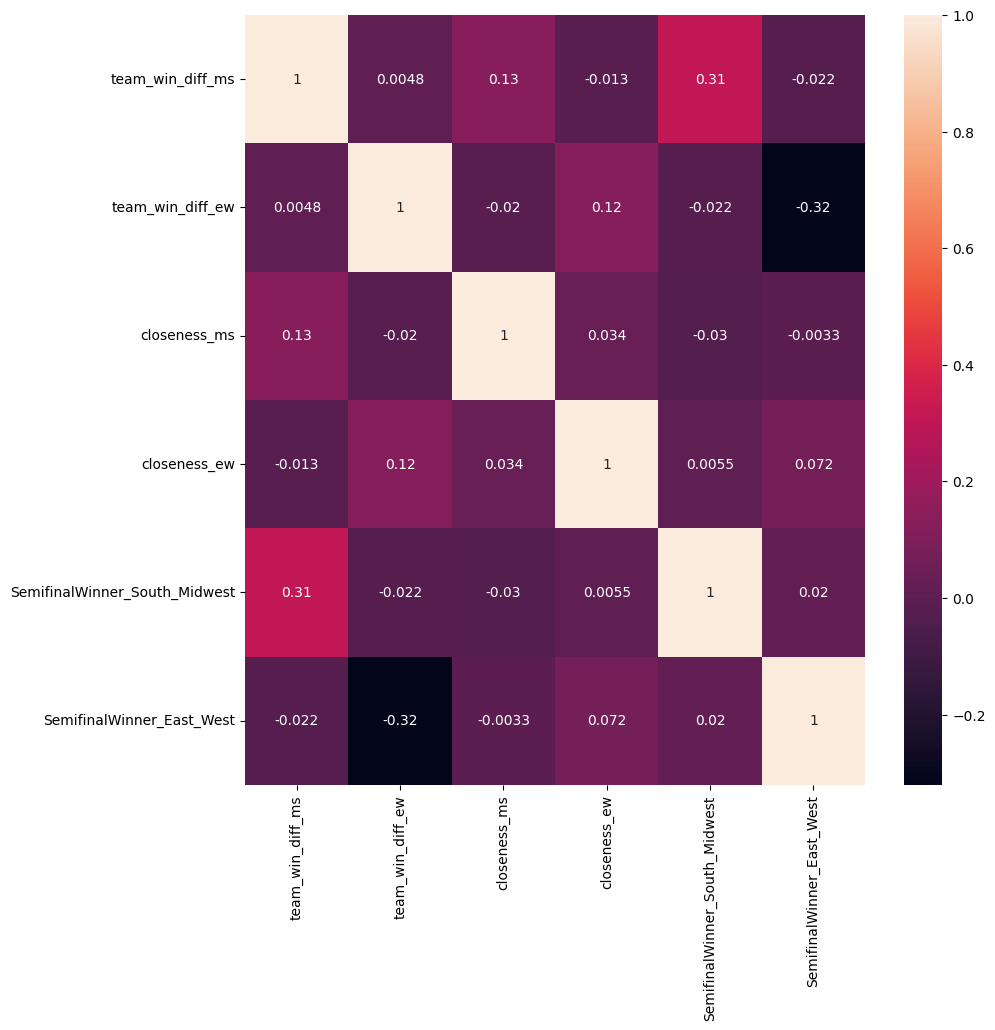

In [65]:
'''Evaluation of Metrics'''
# %pip install openpyxl
corr = model_1_df.loc[:, ['team_win_diff_ms','team_win_diff_ew','closeness_ms', 'closeness_ew','SemifinalWinner_South_Midwest', 'SemifinalWinner_East_West']].corr()

# corr.to_excel('~/Desktop/output.xlsx', index=False)

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.show()


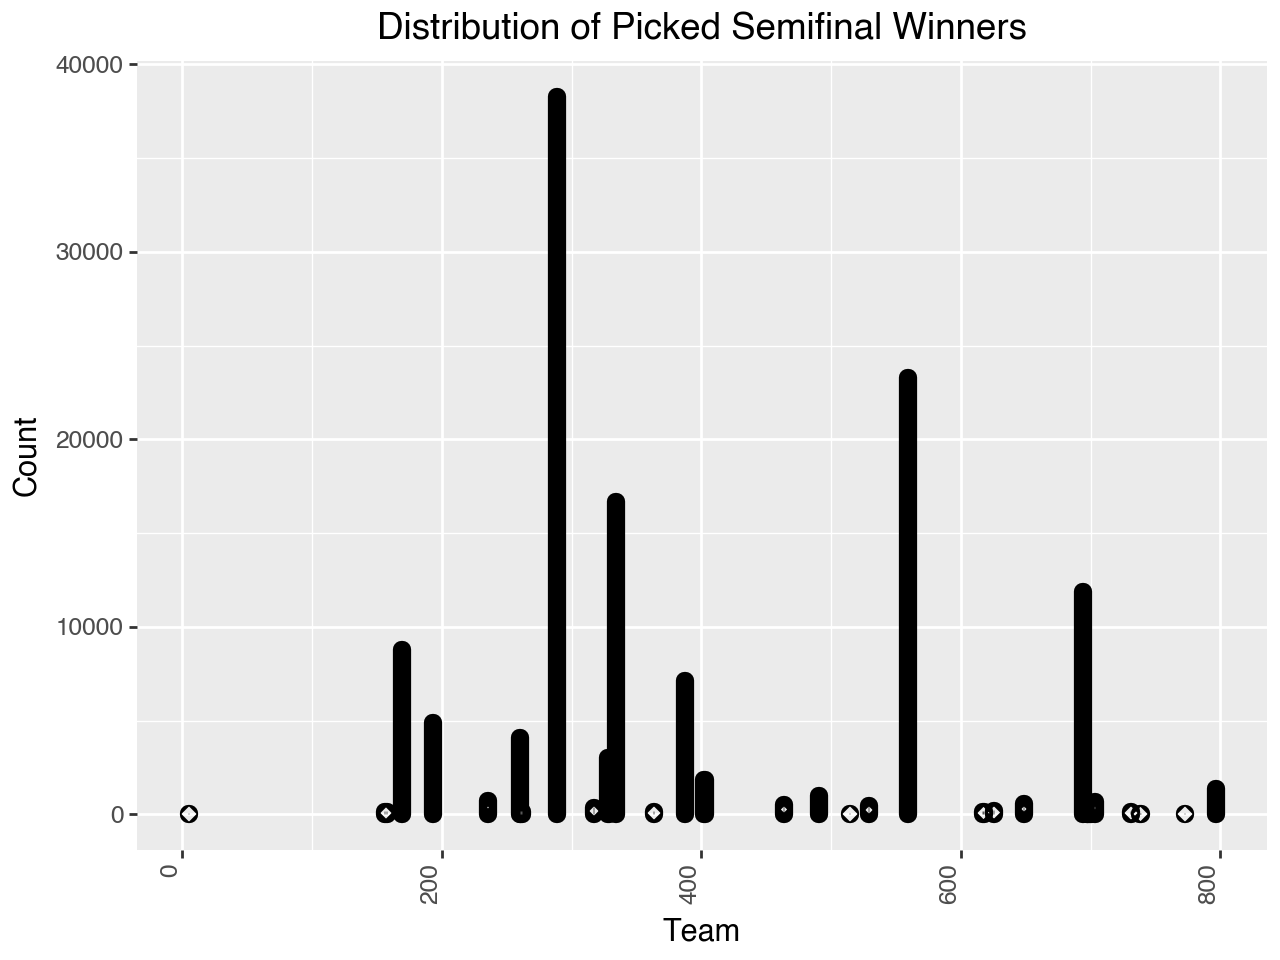

In [66]:
# sns.scatterplot(x=model_1_df['team_win_diff_ms'], y=model_1_df['SemifinalWinner_South_Midwest'])




from plotnine import ggplot, aes, geom_bar, labs, theme, element_text

p = (
    ggplot(model_1_df, aes(x='SemifinalWinner_South_Midwest'))
    + geom_bar(color='black', size = 3.5)
    + labs(x='Team', y='Count', title='Distribution of Picked Semifinal Winners')
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
)

p

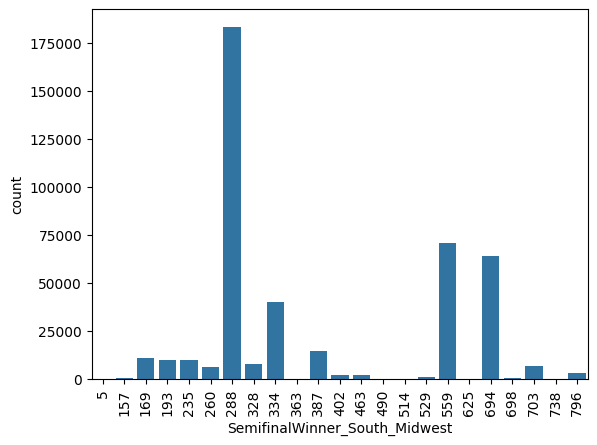

In [23]:
ax_1 = ax_1 = sns.countplot(x=model_1_df['SemifinalWinner_South_Midwest'])
plt.xticks(rotation=90)
plt.show()

In [24]:
college_info[college_info['InstitutionID'] == 288]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
14,288,Houston,Cougars,HOU,Houston,TX,77204,618,HOUSTON,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03


In [25]:
top_picks = college_info[(college_info["InstitutionID"] == 559) |
             (college_info["InstitutionID"] == 334) |
             (college_info["InstitutionID"] == 387) |
             (college_info["InstitutionID"] == 694) |
             (college_info['InstitutionID'] == 169) |
             (college_info["InstitutionID"] == 288)].sort_values('RegularSeasonWins', ascending=False)
top_picks.loc[:, ['InstitutionID', 'InstitutionName', 'InstitutionDMACode','RegularSeasonWins','RegularSeasonLosses','RegularSeasonAverageAttendance' ]]

,InstitutionID,InstitutionName,InstitutionDMACode,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance
14,288,Houston,618,30,4,9347.35
23,559,Purdue,582,29,4,13329.06
13,387,Marquette,617,25,9,14084.65
37,694,Tennessee,557,24,8,16065.47
9,334,Kentucky,541,23,9,17427.94
61,169,Creighton,652,23,9,13651.44


In [26]:
college_info[college_info["InstitutionID"] == 334]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
9,334,Kentucky,Wildcats,UK,Lexington,KY,40506,541,LEXINGTON,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44


In [27]:
college_info[college_info["InstitutionID"] == 387]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
13,387,Marquette,Golden Eagles,MARQ,Milwaukee,WI,53233,617,MILWAUKEE,43.03903,-87.92796,Big East Conference,3328,4200,7528,09/01/1928,25,9,14084.65,78.29


In [28]:
college_info[college_info["InstitutionID"] == 164]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
24,164,UConn,Huskies,UCONN,Storrs,CT,06269,533,HARTFORD & NEW HAVEN,41.8091,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47


In [ ]:
dma_count_groupby = classic1_df_train.groupby(by='CustomerDMACode').agg(semi_midwest_south_count= pd.NamedAgg(column='SemifinalWinner_South_Midwest', aggfunc='count'),
                                              semi_east_west_count= pd.NamedAgg(column='SemifinalWinner_East_West', aggfunc='count'))
dma_count_groupby

,semi_midwest_south_count,semi_east_west_count
CustomerDMACode,,
500.0,719,719
501.0,15432,15432
502.0,347,347
503.0,202,202
504.0,8417,8417
...,...,...
855.0,325,325
862.0,2230,2230
866.0,492,492


In [ ]:
classic1_df_train

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionName,E_InstitutionDMACode,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,E_Rk,E_Seed_Rank,E_NetRtg,E_Luck,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,M_Rk,M_Seed_Rank,M_NetRtg,M_Luck,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,S_Rk,S_Seed_Rank,S_NetRtg,S_Luck,S_InstitutionName,W_InstitutionDMACode,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,W_Rk,W_Seed_Rank,W_NetRtg,W_Luck,bracket_entry_count,m_win_%,s_win_%,e_win_%,w_win_%,closeness_ms,closeness_ew,team_win_diff_ms,team_win_diff_ew
1,3511,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,UConn,533,41.8091,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1.0,1,36.43,0.037,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,27.0,4,17.94,0.058,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,23.0,3,19.29,-0.040,Kentucky,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,15.0,3,21.90,-0.016,2,0.687500,0.718750,0.911765,0.69697,339.558931,-455.466359,-0.031250,0.214795
1,3511,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,UConn,533,41.8091,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1.0,1,36.43,0.037,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,70.0,St.,11.52,0.028,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,23.0,3,19.29,-0.040,Kentucky,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,15.0,3,21.90,-0.016,2,0.687500,0.718750,0.911765,0.69697,339.558931,-455.466359,-0.031250,0.214795
2,58445,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,UConn,533,41.8091,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,1.0,1,36.43,0.037,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,3.0,1,30.62,0.048,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,2.0,1,31.17,0.042,Houston,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,15.0,3,21.90,-0.016,7,0.878788,0.882353,0.911765,0.69697,-1098.391305,-1461.488650,-0.003565,0.214795
2,58445,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,UConn,

In [ ]:
dma_distribution_south_midwest = classic1_df_train.groupby(by =['CustomerDMACode', 'CustomerDMADescription'])['SemifinalWinner_South_Midwest'] \
                                             .value_counts() \
                                             .unstack(fill_value=0)
# dma_distribution_south_midwest.sort_values(559, ascending=False).head(20)

dma_distribution_south_midwest_prop = dma_distribution_south_midwest.div(dma_distribution_south_midwest.sum(axis=1), axis=0)

dma_distribution_south_midwest_prop.sort_values(772, ascending=False).head(10)
top_picks_by_dma = dma_distribution_south_midwest_prop.loc[:,[559, 334, 387, 694, 169, 288, 772]]
top_picks_by_dma['Sum'] = top_picks_by_dma[559] + top_picks_by_dma[334] + top_picks_by_dma[387] + top_picks_by_dma[694] + top_picks_by_dma[169] \
+ top_picks_by_dma[288]


top_picks_by_dma


,SemifinalWinner_South_Midwest,559,334,387,694,169,288,772,Sum
CustomerDMACode,CustomerDMADescription,,,,,,,,
500.0,PORTLAND - AUBURN,0.199219,0.164062,0.054688,0.085938,0.078125,0.246094,0.000000,0.828125
501.0,NEW YORK,0.162795,0.139371,0.059340,0.093305,0.083935,0.270935,0.000976,0.809682
502.0,BINGHAMTON,0.203704,0.185185,0.046296,0.120370,0.046296,0.166667,0.000000,0.768519
503.0,MACON,0.253968,0.142857,0.031746,0.095238,0.079365,0.158730,0.000000,0.761905
504.0,PHILADELPHIA,0.179601,0.131190,0.061345,0.101626,0.083518,0.268662,0.000000,0.825942
...,...,...,...,...,...,...,...,...,...
855.0,SANTABARBRA - SANMAR - SANLUOB,0.215054,0.075269,0.064516,0.053763,0.032258,0.311828,0.000000,0.752688
862.0,SACRAMNTO - STKTN - MODESTO,0.199721,0.113128,0.050279,0.082402,0.057263,0.293296,0.000000,0.796089
866.0,FRESNO - VISALIA,0.267974,0.111111,0.045752,0.058824,0.052288,0.287582,0.000000,0.823529


In [70]:
print(top_picks_by_dma.Sum.mean())

0.8123340775752241


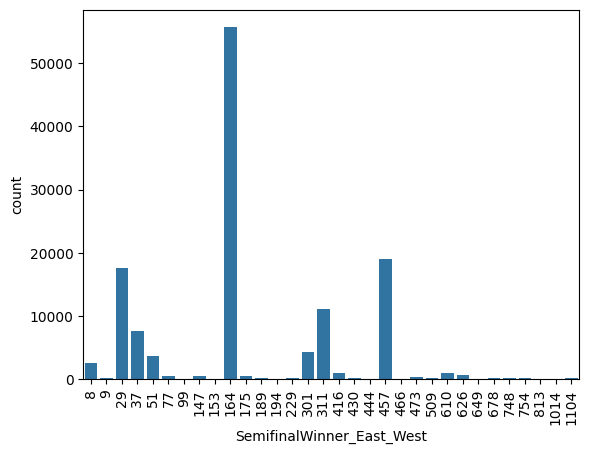

In [71]:
ax_1 = ax_1 = sns.countplot(x=model_1_df['SemifinalWinner_East_West'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
dma_distribution_east_west = classic1_df_train.groupby(by =['CustomerDMACode', 'CustomerDMADescription'])['SemifinalWinner_East_West'] \
                                             .value_counts() \
                                             .unstack(fill_value=0)

dma_distribution_east_west_prop = dma_distribution_east_west.div(dma_distribution_east_west.sum(axis=1), axis=0)


dma_ew = dma_distribution_east_west_prop.loc[:, [29,311,457,164]]
dma_ew['sum'] = dma_ew[29] + dma_ew[311] + dma_ew[457] + dma_ew[164]

dma_ew

,SemifinalWinner_East_West,29,311,457,164,sum
CustomerDMACode,CustomerDMADescription,,,,,
500.0,PORTLAND - AUBURN,0.113281,0.078125,0.167969,0.500000,0.859375
501.0,NEW YORK,0.118680,0.068124,0.148351,0.484287,0.819442
502.0,BINGHAMTON,0.212963,0.055556,0.138889,0.388889,0.796296
503.0,MACON,0.063492,0.047619,0.222222,0.412698,0.746032
504.0,PHILADELPHIA,0.133038,0.072062,0.168884,0.422395,0.796378
...,...,...,...,...,...,...
855.0,SANTABARBRA - SANMAR - SANLUOB,0.129032,0.075269,0.096774,0.537634,0.838710
862.0,SACRAMNTO - STKTN - MODESTO,0.146648,0.076816,0.148045,0.427374,0.798883
866.0,FRESNO - VISALIA,0.143791,0.111111,0.163399,0.431373,0.849673


In [73]:
dma_ew['sum'].mean()

np.float64(0.7965361293158172)

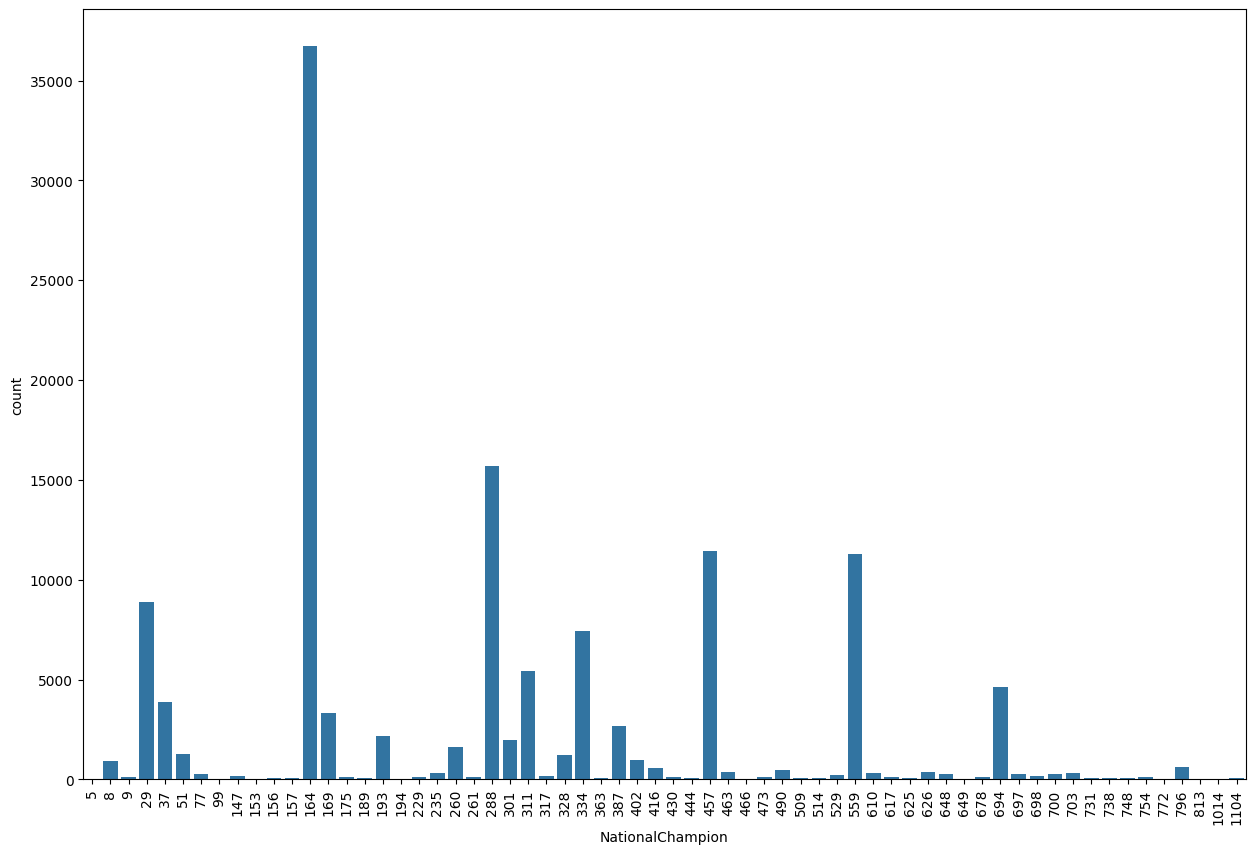

In [ ]:
plt.figure(figsize=(15,10))
ax_1 = ax_1 = sns.countplot(x=model_1_df['NationalChampion'])
plt.xticks(rotation=90)
plt.show()

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Total,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,E_Rk,E_Seed_Rank,E_NetRtg,E_Luck,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,M_Rk,M_Seed_Rank,M_NetRtg,M_Luck,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,S_Rk,S_Seed_Rank,S_NetRtg,S_Luck,W_InstitutionEnrollment_Total,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,W_Rk,W_Seed_Rank,W_NetRtg,W_Luck,bracket_entry_count,closeness
0,47028,32.5622,-86.0994,698.0,MONTGOMERY (SELMA),2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,Big East Conference,10645,22479,31,3,14017.88,81.47,1,1,36.43,0.037,Tennessee,557,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,5,2,26.61,-0.026,James Madison,569,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,63,12,12.42,0.093,30382,25,8,12118.18,87.94,6,2,26.55,-0.047,8,-731.068930
1,3511,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,Big East Conference,10645,22479,31,3,14017.88,81.47,1,1,36.43,0.037,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,27,4,17.94,0.058,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,23,3,19.29,-0.040,14885,23,10,9517.79,80.55,15,3,21.90,-0.016,1,-455.466359
2,58445,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,Big East Conference,10645,22479,31,3,14017.88,81.47,1,1,36.43,0.037,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,3,1,30.62,0.048,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,2,1,31.17,0.042,14885,23,10,9517.79,80.55,15,3,21.90,-0.016,2,-1461.488650
3,28833,29.4969,-98.4032,641.0,SAN ANTONIO,2023-11-16,3384825,2024-03-21 10:28:56 -0400,311,610,490,559,311,490,490,Big 12 Conference,14070,25241,27,7,12059.44,75.56,8,2,26.47,0.002,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,3,1,30.62,0.048,NC State,560,35.78511,-78.67451,Atlantic Coast Conference,11649,11794,23443,09/01/1941,22,14,12147.11,76.36,45,11,15.90,0.014,1949,26,7,3458.15,74.24,20,5,19.43,0.008,8,-916.157340
4,37899,42.8946,-78.8245,514.0,BUFFALO,2022-03-16,2828017,2024-03-20 20:14:52 -0400,37,457,387,169,457,387,457,Southeastern Conference,12695,25379,27,7,10182.91,83.32,4,4,27.99,-0.080,Creighton,652,41.26536,-95.94781,Big East Conference,1789,2501,4290,09/01/1923,23,9,13651.44,80.53,11,3,24.22,-0.018,Marquette,617,43.03903,-87.92796,Big East Conference,3328,4200,7528,09/01/1928,25,9,14084.65,78.29,13,2,23.02,0.035,20242,27,7,15767.47,81.47,9,1,26.19,-0.038,9,508.239129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, make_scorer, recall_score, confusion_matrix

# -------------------------------
# 0. Load Data and Preprocessing (Existing Code)
# -------------------------------

path = os.getcwd()

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

bracket_training = pd.read_csv(f"{path}/bracket_training.csv", sep=",")
bracket_test = pd.read_csv(f'{path}/bracket_test.csv')
college_info = pd.read_csv(f'{path}/institutions.csv', sep=',', encoding='utf-8')
df_kenpom = pd.read_csv('Kenpom Data.csv')
distances_ew_df = pd.read_csv(f'{path}/SemifinalWinner_East_West.csv', sep='|')

# --- Step 1: Process KenPom Data
df_kenpom['Team_Name'] = df_kenpom['Team'].apply(lambda x: ' '.join(x.split()[:-1]))
mapping = {
    "Connecticut": "UConn", "Houston": "Houston", "Purdue": "Purdue", "Auburn": "Auburn",
    "Tennessee": "Tennessee", "Arizona": "Arizona", "Duke": "Duke", "Iowa St.": "Iowa St.",
    "North Carolina": "North Carolina", "Illinois": "Illinois", "Creighton": "Creighton",
    "Gonzaga": "Gonzaga", "Marquette": "Marquette", "Alabama": "Alabama", "Baylor": "Baylor",
    "Michigan St.": "Michigan St.", "Wisconsin": "Wisconsin", "BYU": "BYU", "Clemson": "Clemson",
    "Saint Mary's": "Saint Mary's", "San Diego St.": "San Diego St.", "Kentucky": "Kentucky",
    "Colorado": "Colorado", "Texas": "Texas", "Florida": "Florida", "Kansas": "Kansas",
    "New Mexico": "New Mexico", "Nebraska": "Nebraska", "Texas Tech": "Texas Tech",
    "Dayton": "Dayton", "Mississippi St.": "Mississippi St.", "Texas A&M": "Texas A&M",
    "Colorado St.": "Colorado St.", "Nevada": "Nevada", "Northwestern": "Northwestern",
    "Washington St.": "Washington St.", "TCU": "TCU", "Boise St.": "Boise St.",
    "N.C. State": "NC State", "Florida Atlantic": "FAU", "Utah St.": "Utah St.",
    "Grand Canyon": "Grand Canyon", "Drake": "Drake", "South Carolina": "South Carolina",
    "Oregon": "Oregon", "James Madison": "James Madison", "McNeese St.": "McNeese",
    "Virginia": "Virginia", "Samford": "Samford", "Duquesne": "Duquesne", "Yale": "Yale",
    "Charleston": "Charleston", "Vermont": "Vermont", "UAB": "UAB", "Morehead St.": "Morehead St.",
    "Akron": "Akron", "Oakland": "Oakland", "Western Kentucky": "Western Ky.",
    "South Dakota St.": "South Dakota St.", "Colgate": "Colgate", "Longwood": "Longwood",
    "Long Beach St.": "Long Beach St.", "Saint Peter's": "Saint Peter's", "Stetson": "Stetson",
    "Montana St.": "Montana St.", "Grambling St.": "Grambling St.", "Howard": "Howard", "Wagner": "Wagner"
}
df_kenpom['Team_Name'] = df_kenpom['Team_Name'].map(mapping)
df_kenpom['Seed_Rank'] = df_kenpom['Team'].str.extract(r'(\d+)$')
df_kenpom = df_kenpom.dropna(subset=['Seed_Rank'])
df_kenpom['Seed_Rank'] = df_kenpom['Seed_Rank'].astype(int)
df_ken_clean = df_kenpom.loc[:, ['Rk', 'Team_Name', 'Seed_Rank', 'NetRtg', 'Luck']]
df_ken_clean = df_ken_clean.set_index('Team_Name')

# --- Step 2: Merge with college_info and Join to Bracket Data
college_info_ken_df = college_info.join(df_ken_clean, how='left', on='InstitutionName')
college_info_ken_df['win_%'] = college_info_ken_df['RegularSeasonWins'] / (college_info_ken_df['RegularSeasonWins'] + college_info_ken_df['RegularSeasonLosses'])
college_info_ken_df = college_info_ken_df.set_index('InstitutionID')

train_df = bracket_training.join(
    college_info_ken_df.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_ken_df.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_ken_df.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_ken_df.add_prefix('S_'), on='RegionWinner_South'
)

test_df = bracket_test.join(
    college_info_ken_df.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_ken_df.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_ken_df.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_ken_df.add_prefix('S_'), on='RegionWinner_South'
)

classic1_df_train = train_df[[
    'CustomerID',
    'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude', 'CustomerDMACode', 'CustomerDMADescription',
    'NCAACustomerRecordCreated', 'BracketEntryId', 'BracketEntryCreatedDate',
    'RegionWinner_East', 'RegionWinner_West', 'RegionWinner_South', 'RegionWinner_Midwest',
    'SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest', 'NationalChampion',
    'E_InstitutionName', 'E_InstitutionDMACode', 'E_InstitutionLatitude', 'E_InstitutionLongitude',
    'E_InstitutionConference', 'E_InstitutionEnrollment_Male', 'E_InstitutionEnrollment_Female',
    'E_InstitutionEnrollment_Total', 'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
    'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance', 'E_RegularSeasonAverageScore',
    'E_Rk', 'E_Seed_Rank', 'E_NetRtg', 'E_Luck',
    'M_InstitutionName', 'M_InstitutionDMACode', 'M_InstitutionLatitude', 'M_InstitutionLongitude',
    'M_InstitutionConference', 'M_InstitutionEnrollment_Male', 'M_InstitutionEnrollment_Female',
    'M_InstitutionEnrollment_Total', 'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
    'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance', 'M_RegularSeasonAverageScore',
    'M_Rk', 'M_Seed_Rank', 'M_NetRtg', 'M_Luck',
    'S_InstitutionName', 'S_InstitutionDMACode', 'S_InstitutionLatitude', 'S_InstitutionLongitude',
    'S_InstitutionConference', 'S_InstitutionEnrollment_Male', 'S_InstitutionEnrollment_Female',
    'S_InstitutionEnrollment_Total', 'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
    'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance', 'S_RegularSeasonAverageScore',
    'S_Rk', 'S_Seed_Rank', 'S_NetRtg', 'S_Luck',
    'W_InstitutionName', 'W_InstitutionDMACode', 'W_InstitutionLatitude', 'W_InstitutionLongitude',
    'W_InstitutionConference', 'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female',
    'W_InstitutionEnrollment_Total', 'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
    'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance', 'W_RegularSeasonAverageScore',
    'W_Rk', 'W_Seed_Rank', 'W_NetRtg', 'W_Luck'
]]
classic1_df_test = test_df[[
    'CustomerID',
    'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude', 'CustomerDMACode', 'CustomerDMADescription',
    'NCAACustomerRecordCreated', 'BracketEntryId', 'BracketEntryCreatedDate',
    'RegionWinner_East', 'RegionWinner_West', 'RegionWinner_South', 'RegionWinner_Midwest',
    'E_InstitutionName', 'E_InstitutionDMACode', 'E_InstitutionLatitude', 'E_InstitutionLongitude',
    'E_InstitutionConference', 'E_InstitutionEnrollment_Male', 'E_InstitutionEnrollment_Female',
    'E_InstitutionEnrollment_Total', 'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
    'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance', 'E_RegularSeasonAverageScore',
    'E_Rk', 'E_Seed_Rank', 'E_NetRtg', 'E_Luck',
    'M_InstitutionName', 'M_InstitutionDMACode', 'M_InstitutionLatitude', 'M_InstitutionLongitude',
    'M_InstitutionConference', 'M_InstitutionEnrollment_Male', 'M_InstitutionEnrollment_Female',
    'M_InstitutionEnrollment_Total', 'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
    'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance', 'M_RegularSeasonAverageScore',
    'M_Rk', 'M_Seed_Rank', 'M_NetRtg', 'M_Luck',
    'S_InstitutionName', 'S_InstitutionDMACode', 'S_InstitutionLatitude', 'S_InstitutionLongitude',
    'S_InstitutionConference', 'S_InstitutionEnrollment_Male', 'S_InstitutionEnrollment_Female',
    'S_InstitutionEnrollment_Total', 'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
    'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance', 'S_RegularSeasonAverageScore',
    'S_Rk', 'S_Seed_Rank', 'S_NetRtg', 'S_Luck',
    'W_InstitutionName', 'W_InstitutionDMACode', 'W_InstitutionLatitude', 'W_InstitutionLongitude',
    'W_InstitutionConference', 'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female',
    'W_InstitutionEnrollment_Total', 'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
    'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance', 'W_RegularSeasonAverageScore',
    'W_Rk', 'W_Seed_Rank', 'W_NetRtg', 'W_Luck'
]]
# Create separate imputers:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

# List the columns to impute:
num_cols = ['CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude']
cat_cols = ['CustomerDMACode', 'CustomerDMADescription']

# Impute in the training set:
classic1_df_train[num_cols] = num_imputer.fit_transform(classic1_df_train[num_cols])
classic1_df_train[cat_cols] = cat_imputer.fit_transform(classic1_df_train[cat_cols])

# And in the test set:
classic1_df_test[num_cols] = num_imputer.transform(classic1_df_test[num_cols])
classic1_df_test[cat_cols] = cat_imputer.transform(classic1_df_test[cat_cols])

# Create win percentages
classic1_df_train['m_win_%'] = classic1_df_train['M_RegularSeasonWins'] / (classic1_df_train['M_RegularSeasonWins'] + classic1_df_train['M_RegularSeasonLosses'])
classic1_df_train['s_win_%'] = classic1_df_train['S_RegularSeasonWins'] / (classic1_df_train['S_RegularSeasonWins'] + classic1_df_train['S_RegularSeasonLosses'])
classic1_df_train['e_win_%'] = classic1_df_train['E_RegularSeasonWins'] / (classic1_df_train['E_RegularSeasonWins'] + classic1_df_train['E_RegularSeasonLosses'])
classic1_df_train['w_win_%'] = classic1_df_train['W_RegularSeasonWins'] / (classic1_df_train['W_RegularSeasonWins'] + classic1_df_train['W_RegularSeasonLosses'])

classic1_df_test['m_win_%'] = classic1_df_test['M_RegularSeasonWins'] / (classic1_df_test['M_RegularSeasonWins'] + classic1_df_test['M_RegularSeasonLosses'])
classic1_df_test['s_win_%'] = classic1_df_test['S_RegularSeasonWins'] / (classic1_df_test['S_RegularSeasonWins'] + classic1_df_test['S_RegularSeasonLosses'])
classic1_df_test['e_win_%'] = classic1_df_test['E_RegularSeasonWins'] / (classic1_df_test['E_RegularSeasonWins'] + classic1_df_test['E_RegularSeasonLosses'])
classic1_df_test['w_win_%'] = classic1_df_test['W_RegularSeasonWins'] / (classic1_df_test['W_RegularSeasonWins'] + classic1_df_test['W_RegularSeasonLosses'])

# -------------------------------
# 3. Define Helper Functions for Modeling and Feature Engineering
# -------------------------------

def haversine_distance(lat1, lon1, lat2, lon2):
    """Compute the Haversine distance (in km) between two points."""
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(delta_lon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# (Existing sigmoid_transform function)
def sigmoid_transform(X):
    try:
        return 1 / (1 + np.exp(-X))
    except ZeroDivisionError:
        print('Bad Process!')

sigmoid_transformer = FunctionTransformer(sigmoid_transform, validate=False)

def multioutput_accuracy(y_true, y_pred):
    # y_true and y_pred should be numpy arrays of shape (n_samples, n_outputs)
    accuracies = []
    for i in range(y_true.shape[1]):
        accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    return np.mean(accuracies)

custom_scorer = make_scorer(multioutput_accuracy)

# -------------------------------
# 4. Incorporate New Geographic & Popularity Features
# -------------------------------

# Define team information including latitude, longitude, DMA, Region, and a popularity score.
teams_info = {
    'Purdue':        {'lat': 40.4237, 'lon': -86.9212, 'DMA': 582, 'Region': 'Midwest', 'popularity': 0.60},
    'UConn':         {'lat': 41.8078, 'lon': -72.2534, 'DMA': 533, 'Region': 'East',    'popularity': 0.90},
    'Kentucky':      {'lat': 38.0406, 'lon': -84.5037, 'DMA': 541, 'Region': 'East',    'popularity': 0.75},
    'Marquette':     {'lat': 43.0389, 'lon': -87.9065, 'DMA': 617, 'Region': 'Midwest', 'popularity': 0.55},
    'Tennessee':     {'lat': 35.1495, 'lon': -90.0490, 'DMA': 557, 'Region': 'South',   'popularity': 0.70},
    'Creighton':     {'lat': 41.2565, 'lon': -95.9345, 'DMA': 652, 'Region': 'Midwest', 'popularity': 0.50},
    'Houston':       {'lat': 29.7604, 'lon': -95.3698, 'DMA': 618, 'Region': 'South',   'popularity': 0.65},
    'Arizona':       {'lat': 33.4484, 'lon': -112.0740,'DMA': 789, 'Region': 'West',    'popularity': 0.80},
    'IowaSt':        {'lat': 41.6611, 'lon': -93.6091, 'DMA': 679, 'Region': 'Midwest', 'popularity': 0.60},
    'NorthCarolina': {'lat': 35.7596, 'lon': -79.0193, 'DMA': 560, 'Region': 'East',    'popularity': 0.85}
}

def add_team_features(df, teams_info, alpha=0.5, epsilon=1e-5):
    # Compute distance and distance score for each team.
    for team, info in teams_info.items():
        df[f'{team}_distance'] = df.apply(
            lambda row: haversine_distance(row['CustomerPostalCodeLatitude'],
                                           row['CustomerPostalCodeLongitude'],
                                           info['lat'], info['lon']),
            axis=1
        )
        df[f'{team}_dist_score'] = 1 / (df[f'{team}_distance'] + epsilon)
    # Normalize distance scores to get probabilities.
    dist_score_cols = [f'{team}_dist_score' for team in teams_info.keys()]
    df['total_dist_score'] = df[dist_score_cols].sum(axis=1)
    for team in teams_info.keys():
        df[f'{team}_dist_prob'] = df[f'{team}_dist_score'] / df['total_dist_score']
        # Compute combined score using a weight for distance and (1 - weight) for popularity.
        popularity = teams_info[team]['popularity']
        df[f'{team}_combined_score'] = alpha * df[f'{team}_dist_prob'] + (1 - alpha) * popularity
    # Identify the closest team based solely on distance.
    def get_closest_team(row):
        distances = {team: row[f'{team}_distance'] for team in teams_info.keys()}
        return min(distances, key=distances.get)
    df['closest_to_customer'] = df.apply(get_closest_team, axis=1)
    # Identify the predicted team using the highest combined score.
    def get_predicted_team(row):
        scores = {team: row[f'{team}_combined_score'] for team in teams_info.keys()}
        return max(scores, key=scores.get)
    df['predicted_team'] = df.apply(get_predicted_team, axis=1)
    # Flag die-hard fan behavior: when the closest team equals the predicted (combined score) team.
    df['die_hard_fan_location'] = (df['closest_to_customer'] == df['predicted_team']).astype(int)
    # Record the combined score (bias) for the predicted team.
    def get_favorite_team_bias(row):
        return row[f"{row['predicted_team']}_combined_score"]
    df['favorite_team_bias'] = df.apply(get_favorite_team_bias, axis=1)
    return df

# Apply the new features to both training and test sets.
df_train = classic1_df_train.copy()
df_test = classic1_df_test.copy()
df_train = add_team_features(df_train, teams_info, alpha=0.5, epsilon=1e-5)
df_test = add_team_features(df_test, teams_info, alpha=0.5, epsilon=1e-5)

# -------------------------------
# 5. Define Feature Columns and Multi-Output Targets for Joint Modeling
# -------------------------------

# Drop withheld features
features_to_withHold = [
    'E_InstitutionName', 'E_InstitutionDMACode', 'E_InstitutionLatitude', 'E_InstitutionLongitude',
    'E_InstitutionNCAAMemberSinceDate', 'E_InstitutionEnrollment_Female',
    'W_InstitutionName', 'W_InstitutionDMACode', 'W_InstitutionLatitude', 'W_InstitutionLongitude',
    'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female', 'W_InstitutionNCAAMemberSinceDate',
    'M_InstitutionName',
 'M_InstitutionDMACode',
 'M_InstitutionLatitude',
 'M_InstitutionLongitude',
 'M_InstitutionNCAAMemberSinceDate',
 'M_InstitutionEnrollment_Female',
 'S_InstitutionName',
 'S_InstitutionDMACode',
 'S_InstitutionLatitude',
 'S_InstitutionLongitude',
 'S_InstitutionEnrollment_Male',
 'S_InstitutionEnrollment_Female',
 'S_InstitutionNCAAMemberSinceDate'
]

df_train = df_train.drop(columns=features_to_withHold)
df_test = df_test.drop(columns=features_to_withHold)


# Create lists of features based on column name prefixes.
features_east = [col for col in df_train.columns if col.startswith('E_')]
features_west = [col for col in df_train.columns if col.startswith('W_')]

# Define target column names.
target_EW = "SemifinalWinner_East_West"    # outcome for East-West semifinal
target_MS = "SemifinalWinner_South_Midwest"  # outcome for South-Midwest semifinal
target_NC = "NationalChampion"             # outcome for National Champion

# Remove target columns from the feature lists if present.
for target in [target_EW, target_MS]:
    if target in features_east: features_east.remove(target)
    if target in features_west: features_west.remove(target)

# Combine feature lists.
features = features_east + features_west

# Add our new engineered features.
new_features = ['closest_to_customer', 'predicted_team', 'die_hard_fan_location', 'favorite_team_bias']
features.extend(new_features)

# Create a multi-output target DataFrame.
# For this example, we encode the semifinal winners as binary outcomes.
y_multi = pd.DataFrame({
    target_EW: (df_train[target_EW] == df_train['RegionWinner_East']).astype(int),
    target_MS: (df_train[target_MS] == df_train['RegionWinner_Midwest']).astype(int),
    target_NC: df_train[target_NC]  # Assuming NationalChampion is pre-encoded or categorical.
})

# -------------------------------
# 6. Build a Shared Preprocessing Pipeline
# -------------------------------

# Define non-numeric columns. We add our categorical new features.
non_numeric_columns = ['E_InstitutionConference', 'W_InstitutionConference', 'closest_to_customer', 'predicted_team']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in features if col not in non_numeric_columns]),
        ('cat', OneHotEncoder(), non_numeric_columns)
    ]
)

# -------------------------------
# 7. Build the Joint Multi-Task Model
# -------------------------------


multi_task_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

hyperparameter_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10]
}

#KFold cross-validation

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(multi_task_model, param_grid=hyperparameter_grid, cv=cv, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(df_train[features], y_multi)

print("Best CV Accuracy:", grid_search.best_score_)

# -------------------------------
# 8. Predict on New (Test) Data and Save Predictions
# -------------------------------

y_pred_multi = grid_search.predict(df_test[features])
predictions = pd.DataFrame(y_pred_multi, columns=[target_EW, target_MS, target_NC])

predictions[target_EW] = np.where(
    predictions[target_EW] == 1,
    df_test['RegionWinner_East'].values,
    df_test['RegionWinner_West'].values
)
# For SemifinalWinner_South_Midwest: if binary 1 → RegionWinner_Midwest; 0 → RegionWinner_South.
predictions[target_MS] = np.where(
    predictions[target_MS] == 1,
    df_test['RegionWinner_Midwest'].values,
    df_test['RegionWinner_South'].values
)
# Assume NationalChampion is already in the desired institution ID format.

# -------------------------------
# 9. Merge with BracketEntryID and Save CSV
# -------------------------------
# We assume the test DataFrame contains 'BracketEntryId'
predictions['BracketEntryId'] = df_test['BracketEntryId'].values

# Reorder columns as needed:
final_cols = ['BracketEntryId', target_MS, target_EW, target_NC]
final_predictions = predictions[final_cols]

final_predictions.to_csv("predictions_joint_final.csv", index=False)
print("Final predictions saved to predictions_joint_final.csv ✅")


/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_2283/3893260464.py:28: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  distances_ew_df = pd.read_csv(f'{path}/SemifinalWinner_East_West.csv', sep='|')
/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_2283/3893260464.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic1_df_train[num_cols] = num_imputer.fit_transform(classic1_df_train[num_cols])
/var/folders/40/t1rj18bn0m7gjwdx4lsq57tm0000gn/T/ipykernel_2283/3893260464.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [ ]:
joint_predictions = pd.read_csv(f'{path}/predictions_joint.csv')
joint_predictions

,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion
0,0,0,457
1,0,0,457
2,1,0,334
3,1,1,164
4,0,0,457
...,...,...,...
14345,0,0,29
14346,1,0,164
14347,1,1,77
14348,1,0,387


In [58]:
# Create new columns that map the binary outcomes back to institution IDs
predictions['SemifinalWinner_East_West'] = np.where(
    predictions['SemifinalWinner_East_West'] == 1,
    classic1_df_test['RegionWinner_East'].values,
    classic1_df_test['RegionWinner_West'].values
)

predictions['SemifinalWinner_South_Midwest'] = np.where(
    predictions['SemifinalWinner_South_Midwest'] == 1,
    classic1_df_test['RegionWinner_Midwest'].values,
    classic1_df_test['RegionWinner_South'].values
)

# # Optionally, you can drop the binary columns if you no longer need them:
# predictions = predictions.drop(columns=['SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest'])

# Save the final predictions (which now have institution IDs) to CSV
predictions.to_csv("predictions_joint_mapped.csv", index=False)
print("Mapped predictions saved to predictions_joint_mapped.csv ✅")

Mapped predictions saved to predictions_joint_mapped.csv ✅
